# **Generación de Datos para la Ecuación de Cahn-Hilliard**

En este código se construyen los conjuntos de entrenamiento y testeo para la ecuación de Cahn-Hilliard, resolviendo a partir de una condición inicial (ruido) y retornando su solución en el tiempo $T$.


In [2]:
# Importar Librerías
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation
from matplotlib.animation import FuncAnimation


start_time= time.time()

In [3]:
# Definición de parámetros

# Espaciales
nx, ny = 64, 64
Lx, Ly = 1.0, 1.0
x_values = np.linspace(0, Lx, nx, endpoint=False)
y_values = np.linspace(0, Ly, ny, endpoint=False)
X, Y = torch.meshgrid(torch.tensor(x_values), torch.tensor(y_values), indexing="ij")
h = x_values[1] - x_values[0]

# Temporales
dt = 1e-5
n_step = 10000

# Coeficientes de la EDP
gamma = 1e-2

# Tamaño del Batch
batch_size = 32

In [4]:
# Crear directorio para guardar datos
data_dir = Path("../data/cahn_hilliard_data")
data_dir.mkdir(parents=True, exist_ok=True)

## **Solver usando Diferencias Finitas**

Queremos resolver la ecuación

$$\frac{\partial c}{ \partial t} = D \nabla^2(\mu) = D \nabla^2(c^3 - c - \gamma \nabla^2 c)$$

la cual describe el proceso de separación de fases, por el cual los dos componentes de un fluido binario se separan espontáneamente y forman dominios puros en cada componente.

En particular, 
- $c$ : **concentración del fluido**, con $c \pm 1$ indicando los dominios asociados.
- $D$ : es el **coeficiente de difusión** $(m^2/s)$
- $\sqrt{\gamma}$ : es la **longitud de las regiones de transición** entre los dominios
- $\mu$ : corresponde al **potencial químico**.



In [5]:
laplacian = lambda c: (
    np.roll(c, 1, axis=0) + np.roll(c, -1, axis=0) +
    np.roll(c, 1, axis=1) + np.roll(c, -1, axis=1) -
    4 * c
) / h**2

def evolve_cahn_hilliard(c0, n_step, dt, gamma, h):
    c = c0.copy()
    for _ in range(n_step):
        mu = c**3 - c - gamma**2 * laplacian(c)
        c += dt * laplacian(mu)
    return c

## **Generar Datos de Train y Test**

Para construir los conjuntos de entrenamiento y test debemos generar pares $a_j$ y $u_j$ con la estructura adecuada. Consideraremos 1024 pares de entrenamiento y 192 pares de test con paquetes de tamaño 32 (*batch_size*)

En este caso $a_j$ será ruido blanco sobre una malla de $(nx,ny)$ puntos y $u_j$ es la solución de la EDP en el tiempo final $T$.

In [ ]:
N_train = 1024

a = torch.zeros(N_train, nx, ny)
u = torch.zeros(N_train, nx, ny)

i = 0
for j in range(N_train // batch_size):
    print(f"Batch {j}/{N_train // batch_size}")

    # Condición inicial: Ruido uniforme en [-1,1]
    u0 = 2 * torch.rand(batch_size, nx, ny) - 1

    u_batch = []
    for k in range(batch_size):
        u_end = evolve_cahn_hilliard(u0[k].numpy(), n_step, dt, gamma, h)
        u_batch.append(u_end)

    u_batch = torch.tensor(np.array(u_batch), dtype=torch.float32)

    a[i:(i + batch_size), ...] = u0
    u[i:(i + batch_size), ...] = u_batch
    i += batch_size

x_train = a
y_train = u

torch.save({"x": x_train, "y": y_train}, data_dir / f"cahn_hilliard_train_{nx}.pt")
print(f"Datos de entrenamiento guardados en '{data_dir / f'cahn_hilliard_train_{nx}.pt'}'")

In [ ]:
# Datos de Testeo
N_test = 192

# Definir Tensores con los datos
a = torch.zeros(N_test, nx, ny)
u = torch.zeros(N_test, nx, ny)


# Ciclo Principal
i = 0
for j in range(N_test // batch_size):
    print(f"Batch {j}/{N_train // batch_size}")

    # Condición inicial: Ruido uniforme en [-1,1]
    u0 = 2 * torch.rand(batch_size, nx, ny) - 1

    u_batch = []
    for k in range(batch_size):
        u_end = evolve_cahn_hilliard(u0[k].numpy(), n_step, dt, gamma, h)
        u_batch.append(u_end)

    u_batch = torch.tensor(np.array(u_batch), dtype=torch.float32)

    a[i:(i + batch_size), ...] = u0
    u[i:(i + batch_size), ...] = u_batch
    i += batch_size

x_test = a
y_test = u

torch.save({"x": x_test, "y": y_test}, data_dir / f"cahn_hilliard_test_{nx}.pt")
print(f"Datos de entrenamiento guardados en '{data_dir / f'cahn_hilliard_test_{nx}.pt'}'")

In [ ]:
end_time = time.time()
print("El tiempo de ejecución para crear los datasets fue de : ", end_time - start_time, " segundos")

## **Visualización**

A continuación se presenta un código para generar un archivo en formato GIF que muestra la evolución de la solución. Es importante que el parámetro $dt$ sea suficientemente pequeño, sino aparecerán errores del tipo $\texttt{RuntimeWarning}$.

In [6]:
# Parámetros
n = 128
gamma = 1e-2         
dt = 1e-6       
n_step = 10000 
skip_frame = 100       
x, h = np.linspace(0, 1, n, endpoint=False, retstep=True)

def evolve_cahn_hilliard_track(c0, n_step, dt, gamma, h, skip_frame=1):
    c = c0.copy()
    u = []
    for step in range(n_step):
        mu = c**3 - c - gamma**2 * laplacian(c)
        c += dt * laplacian(mu)
        if step % skip_frame == 0:
            u.append(c.copy())
    return u

c0 = 2 * np.random.rand(n, n) - 1
u = evolve_cahn_hilliard_track(c0, n_step, dt, gamma, h, skip_frame)

fig, ax = plt.subplots()
img = ax.imshow(u[0], cmap="viridis", vmin=-1, vmax=1)
title = ax.text(0.5, 0.1, '', transform=ax.transAxes,
                ha='center', bbox={'facecolor': 'w', 'alpha': 0.7, 'pad': 5})
ax.axis("off")
fig.colorbar(img, ax=ax)

def update(i):
    img.set_data(u[i])
    title.set_text(f"Time = {i * skip_frame * dt:.6f} s")
    return img, title

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(u), interval=1, blit=True)

# Guardar como GIF
ani.save("cahn_hilliard_animation.gif", writer=animation.PillowWriter(fps=24))
print("GIF guardado como cahn_hilliard_animation.gif")
plt.close(fig)

GIF guardado como cahn_hilliard_animation.gif


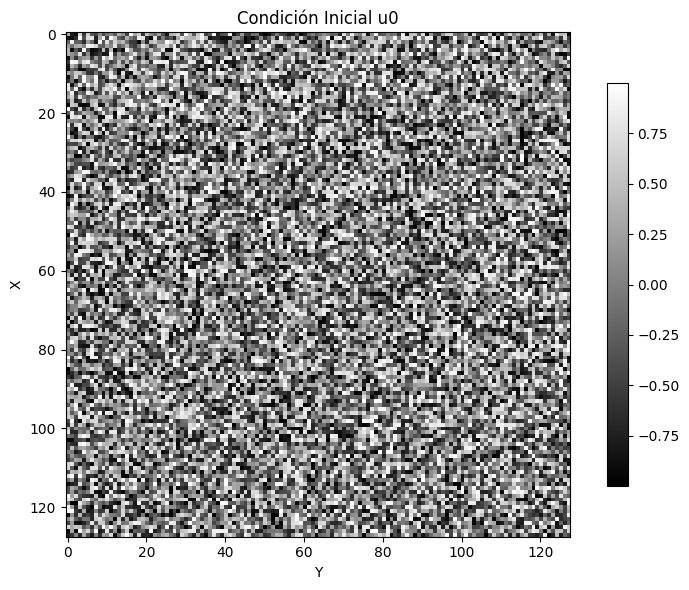

In [7]:
# Visualizar Condición Inicial
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

im = ax.imshow(c0, cmap="gray")

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_title('Condición Inicial u0')

fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

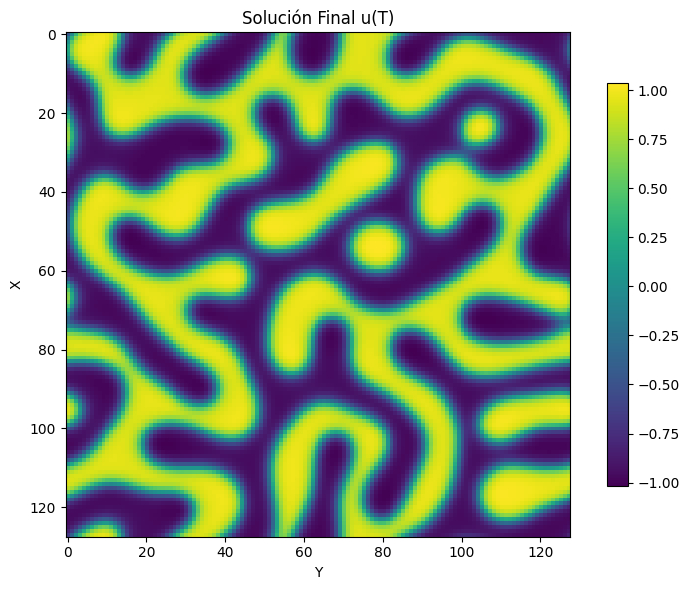

In [8]:
# Visualización Solución Final
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

im = ax.imshow(u[-1], cmap="viridis")

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_title('Solución Final u(T)')

fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()